# Fall detector
## \[5ARB0\] Data Acquisition and Analysis - Technical Assignment

In [12]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages
from helpers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

## Introduction
In this assignment you will use the previously learned data analysis methods and apply them to create a fall detector. After collecting and preprocessing sensor recording, you will extract a set of features which you will use for creating a fall detector.

This assignment is split into 4 parts. Parts 1-3 encompass the collection, preprocessing and feature extraction of sensor recordings. Finally, in part 4 you will create a fall detector.

### Learning goals
After this assignment you can
- collect data according to a protocol;
- load and merge datasets;
- preprocess data;
- extract features from data;
- apply analysis methods for creating a fall detector.

## Part 1: Data collection

Collect the data according to the data collection protocol provided on Canvas.

> (For iPhone) If you have issues accessing the (live) calibrated data of the _Sensor Logger_ app, you need to enable motion and compas calibration on your phone as explained [here](https://www.lifewire.com/how-to-calibrate-an-iphone-4172146). You will notice this once the live view and the export yield empty results.

## Part 2: Data cleaning and preprocessing
In this part you will be working on cleaning and preprocessing the data that you have gathered for further analysis.


---
---
### Exercise 2.1: Read, merge and select data
Load one of your individuals recordings in a Pandas DataFrame called `data`. You may want to have a look at the `pd.merge_asof` function to combine the recordings of the different sensors. Make sure that the `data` dataframe does not contain any `NaN`'s or empty fields as a result of different sampling frequencies. Any columns/recordings that you will not be using in your experiment should be removed from `data` (except for the `seconds_elapsed` column). Also remove duplicate colums. In the end your dataframe should have an indexing column, a column called `seconds_elapsed`, followed by the columns corresponding to the measurements.

In [13]:
#// BEGIN_TODO [5ARB0_FallDetector_2_1] Read, merge and select data

def readDataFromCSV(acc_CSV, grav_CSV, gyro_CSV):
    '''
    Reads the data from the CSV files and returns them
    :params: the 3 datasets to be read
    returns 3 datasets as a dataframe
    '''
    acc_df = pd.read_csv(acc_CSV)
    gyro_df = pd.read_csv(gyro_CSV)
    grav_df = pd.read_csv(grav_CSV)
    return acc_df, grav_df, gyro_df

def MergeDatasets(acc_df, grav_df, gyro_df):
    '''
    Merges the datasets given as params
    :params: the 3 datasets to be merged
    returns a dataframe
    '''
    tolerance = 0.1
    # combine acc and gyro
    df = pd.merge_asof(acc_df, gyro_df, on='seconds_elapsed', suffixes=['', '_gyro'], tolerance= tolerance, direction='nearest')
    # combine acc+gyro and grav
    df = pd.merge_asof(df, grav_df, on='seconds_elapsed', suffixes=['_acc', '_grav'], tolerance= tolerance, direction='nearest')

    #remove unused columns, nan and duplicates
    df = df.drop(columns=['time_acc', 'time_gyro', 'time_grav']).drop_duplicates().dropna()

    return df

#// END_TODO [5ARB0_FallDetector_2_1]

In [14]:
# Daniel's stand condition, trial 1
dnl_acc_CSV = "./RawDataDaniel/1/Accelerometer.csv"
dnl_grav_CSV = "./RawDataDaniel/1/Gravity.csv"
dnl_gyro_CSV = "./RawDataDaniel/1/Gyroscope.csv"

# read data
dnl_acc_df, dnl_gyro_df, dnl_grav_df = readDataFromCSV(dnl_acc_CSV, dnl_gyro_CSV, dnl_grav_CSV)
# merge data
data = MergeDatasets(dnl_acc_df, dnl_gyro_df, dnl_grav_df)

#show data
data

,seconds_elapsed,z_acc,y_acc,x_acc,z_gyro,y_gyro,x_gyro,z_grav,y_grav,x_grav
0,0.181474,-0.144901,-0.744139,0.841894,9.234075,3.238918,0.641617,-0.332229,-0.327835,-0.316383
1,0.191550,-0.553501,-0.553539,0.701970,9.251196,3.139842,0.852740,-0.359926,-0.638892,-0.287621
2,0.201526,-0.466423,0.675046,-0.890756,9.219491,3.255075,0.758866,-0.346078,-0.744220,-0.249405
3,0.211591,-0.790283,1.772664,-1.988650,9.140160,3.516239,0.513749,-0.171374,-0.536627,-0.147140
4,0.221609,-1.122013,0.180161,0.442839,9.109326,3.583724,0.589478,0.003196,-0.137286,0.009454
...,...,...,...,...,...,...,...,...,...,...
3096,31.242184,0.127619,0.006226,0.275355,9.465939,2.452832,-0.741624,0.055394,0.260057,-0.314253
3097,31.252216,0.307713,0.003589,0.133389,9.471921,2.421639,-0.767305,0.059655,0.289885,-0.331297
3098,31.262244,0.488194,0.103491,-0.079645,9.476990,2.393137,-0.793698,0.076699,0.296276,-0.305731
3099,31.272276,0.505066,0.155722,-0.101475,9.480104,2.372149,-0.819098,0.105461,0.283493,-0.234491


### End of exercise 2.1
---
---

In order to restrict our focus to fall detection, we would like to trim the recorded segment. In this way we can remove the movements corresponding to starting and stopping the sensor logger app. 

---
---
### Exercise 2.2: Trim data
Remove the first and last 5 seconds of the recordings for this purpose and save this trimmed data frame to `data_trimmed`. Make sure that your code works for a data frame containing an arbitrary number of columns.

In [15]:
#// BEGIN_TODO [5ARB0_FallDetector_2_2] Trim data

def trimDataset(data: pd.DataFrame, fromStart= 5, fromEnd=5):
    '''
    Removes 'fromStart' number of seconds from the beginning of the sample and removes 'fromEnd' number of seconds from the end of sample.
    :fromStart: the number of seconds to be removed from the beginning of the record
    :fromEnd: the number of seconds to be removed from the end of the record
    @returns the trimmed dataset
    '''
    
    # from the beginning
    data = data.drop(
        data[data['seconds_elapsed'] < fromStart].index
    )

    # from the end
    data = data.drop(
        data[data['seconds_elapsed'] > data['seconds_elapsed'].max() - fromEnd].index
    )

    # reset the index whilst removing old index column
    return data.reset_index(drop=True)

#// END_TODO [5ARB0_FallDetector_2_2]

In [16]:
data_trimmed = trimDataset(data)
data_trimmed

,seconds_elapsed,z_acc,y_acc,x_acc,z_gyro,y_gyro,x_gyro,z_grav,y_grav,x_grav
0,5.007255,-3.098820,0.643170,0.703164,-4.151007,-8.004721,-3.855382,-0.100002,-0.360858,-0.258859
1,5.017289,-2.556271,1.215030,0.949696,-4.152784,-8.002533,-3.858011,-0.137286,-0.378968,-0.120508
2,5.027324,-1.948471,1.544908,1.161602,-4.138910,-8.008696,-3.860132,-0.174570,-0.437557,0.035021
3,5.037358,-0.801726,0.936840,0.476300,-4.108057,-8.024540,-3.860182,-0.240616,-0.483363,0.184157
4,5.047386,1.059777,-0.768844,-2.466857,-4.037939,-8.059781,-3.860746,-0.319446,-0.519582,0.571780
...,...,...,...,...,...,...,...,...,...,...
2116,26.236061,0.038116,0.076990,0.041715,-9.634747,-1.602809,0.879232,0.002131,0.008655,-0.003329
2117,26.246095,-0.004859,0.061053,0.054593,-9.634876,-1.601185,0.880770,-0.003196,0.005459,-0.005459
2118,26.256127,-0.028309,0.068987,0.071802,-9.634989,-1.599420,0.882744,-0.007457,0.006525,-0.004394
2119,26.266163,-0.084436,0.006622,0.055421,-9.634871,-1.599052,0.884691,-0.010653,0.009721,0.000932


### End of exercise 2.2
---
---

---
---
### Exercise 2.3: Normalize recordings
For improved processing, the recordings should be normalized. Normalize the recordings by subtracting its mean and by then dividing by its standard deviation. Perform this normalization for each column individually. Save your normalized data in the the data frame `data_norm`.

In [17]:
#// BEGIN_TODO [5ARB0_FallDetector_2_3] Normalize recordings

# ===== =====> Replace this line by your code. <===== ===== #

def normaliseDataset(df: pd.DataFrame):
    # dataset[column] -= dataset[column].mean()
    # dataset[column] /= dataset[column].std()
    # normalized_df = (df[]-df.mean())/df.std()
    
    _, x = df.shape
    for i in range(1, x):
        df.iloc[:,i] -= df.iloc[:,i].mean()
        df.iloc[:,i] /= df.iloc[:,i].std()

    return df

#// END_TODO [5ARB0_FallDetector_2_3]

In [18]:
data_norm = normaliseDataset(data_trimmed) 
data_norm 
# ? normalize seconds as well? 
# No, seconds is not normalized as you will end up with negative seconds. 
# Seconds is basicaly a representative of each row and not a feature.

,seconds_elapsed,z_acc,y_acc,x_acc,z_gyro,y_gyro,x_gyro,z_grav,y_grav,x_grav
0,5.007255,-0.897104,0.309553,0.363221,0.187852,-0.636313,-1.191490,0.033618,-0.374176,-0.150202
1,5.017289,-0.757470,0.487978,0.499796,0.187451,-0.635696,-1.192869,-0.052779,-0.390634,-0.065857
2,5.027324,-0.601042,0.590902,0.617189,0.190585,-0.637435,-1.193982,-0.139177,-0.443880,0.028959
3,5.037358,-0.305908,0.401180,0.237541,0.197554,-0.641905,-1.194008,-0.292224,-0.485508,0.119879
4,5.047386,0.173182,-0.131005,-1.392925,0.213392,-0.651848,-1.194304,-0.474893,-0.518424,0.356189
...,...,...,...,...,...,...,...,...,...,...
2116,26.236061,-0.089760,0.132901,-0.003213,-1.050822,1.169932,1.292063,0.270286,-0.038365,0.005580
2117,26.246095,-0.100820,0.127928,0.003922,-1.050852,1.170390,1.292870,0.257943,-0.041269,0.004281
2118,26.256127,-0.106856,0.130404,0.013455,-1.050877,1.170888,1.293906,0.248069,-0.040301,0.004930
2119,26.266163,-0.121301,0.110946,0.004380,-1.050850,1.170992,1.294927,0.240664,-0.037397,0.008177


### End of exercise 2.3
---
---

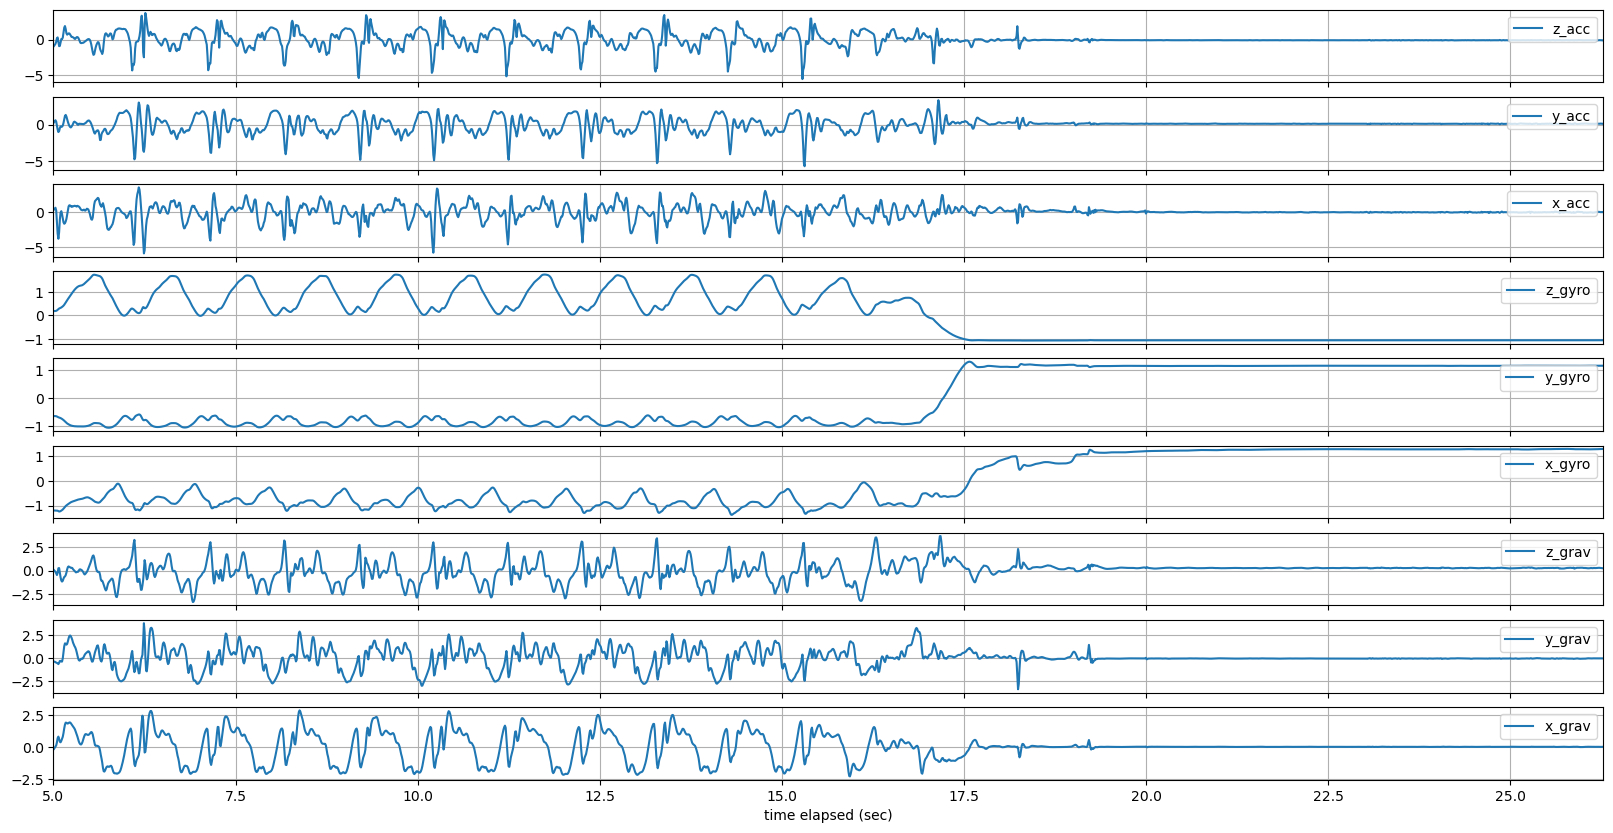

In [19]:
# plot recordings
ex2_plot_data(data_norm)

## Part 3: Feature extraction
The current data is not yet suited for detecting a fall. Based on the measurements at a specific point of time, it is difficult to determine whether someone has allen. Instead, it would be more appropriate to perform the fall detection over _segments_ of time. In this part you will extract features that will be used for detecting falls. But first all collected datasets will be processed.

---
---
### Exercise 3.1: Merge all datasets
Before starting the feature extraction, merge all the preprocessed datasets obtained in the protocol. You will need to load all recording, and again perform all preprocessing steps of Part 2 for the individual recordings. Make sure your code adheres to proper coding standards (make it look nice, don't copy part 2 15 times). Save your merged data in the the data frame `data_merged`.

In [20]:
#// BEGIN_TODO [5ARB0_FallDetector_3_1] Merge all datasets
#
# paths = ['./RawDataDaniel/', './RawDataErik/', './RawData_Aryan/']
# samples = []
# data_merged = pd.DataFrame()

# # read and process each sample
# for path in paths:
#     filesCsv = os.listdir()
#     for i in range(15):
#         path = path + str(i) 
#         samples.append(
#             MergeDatasets(
#                 readDataFromCSV(path + 'Accelerometer.csv', path + 'Gravity.csv', path + 'Gyroscope.csv')))

# # trim and normalise
# for sample in samples:
#     sample = trimDataset(sample)
#     sample = normaliseDataset(sample)
#     pd.concat(data_merged, sample)




def dataLoader(parent_folders, sensors):
    """
    Converts csv files into dataframe and merges all sensor data of each trial
    
    :returns: aryn_data, dnl_data, erk_data (Type: array)

    :All data is stored in matrix.
    Each row contains recording trials

    :Column - Data
    : 0 - accelerometer data
    : 1 - gravity data
    : 2 - gyroscope data
    """

    # Make empty arrays
    aryn_RawData_CSV = np.empty((15, 3), dtype='U1000')
    dnl_RawData_CSV = np.empty((15, 3), dtype='U1000')  
    erk_RawData_CSV = np.empty((15, 3), dtype='U1000')

    aryn_RawData_df = np.empty((15,3), dtype=object)
    dnl_RawData_df = np.empty((15,3), dtype=object)
    erk_RawData_df = np.empty((15,3), dtype=object)

    aryn_Data = np.empty((15,1), dtype=object)
    dnl_Data = np.empty((15,1), dtype=object)
    erk_Data = np.empty((15,1), dtype=object)

    # initialize variables for while loop
    member = 0
    trial_no = 0
    k = 0

    trials_15 = list(range(1, 16))
    

    while member < 3:
        path = "./" + parent_folders[member] + "/"
        while trial_no < 15:
            path = path + str(trials_15[trial_no]) + "/"

            # Reading different sensor files of each member [0-Aryan, 1-Daniel, 2-Erik]
            while k < 3:
                if member == 0:
                    aryn_RawData_CSV[trial_no, k] = path + sensors[k]
                    k += 1
                elif member == 1:
                    dnl_RawData_CSV[trial_no, k] = path + sensors[k]
                    k += 1
                elif member == 2:
                    erk_RawData_CSV[trial_no, k] = path + sensors[k]
                    k += 1
                    
            # reset
            k = 0
            path = "./" + parent_folders[member] + "/"

            # convert into dataframe and merge
            if member == 0:
                # CSV - df
                aryn_RawData_df[trial_no, 0], aryn_RawData_df[trial_no, 1], aryn_RawData_df[trial_no, 2] = readDataFromCSV(aryn_RawData_CSV[trial_no, 0], aryn_RawData_CSV[trial_no, 1], aryn_RawData_CSV[trial_no, 2])
                # merge
                aryn_Data[trial_no, 0] = MergeDatasets(aryn_RawData_df[trial_no, 0], aryn_RawData_df[trial_no, 1], aryn_RawData_df[trial_no, 2])

            elif member == 1:
                # CSV - df
                dnl_RawData_df[trial_no, 0], dnl_RawData_df[trial_no, 1], dnl_RawData_df[trial_no, 2] = readDataFromCSV(dnl_RawData_CSV[trial_no, 0], dnl_RawData_CSV[trial_no, 1], dnl_RawData_CSV[trial_no, 2])
                # merge
                dnl_Data[trial_no, 0] = MergeDatasets(dnl_RawData_df[trial_no, 0], dnl_RawData_df[trial_no, 1], dnl_RawData_df[trial_no, 2])
            
            elif member == 2:
                # CSV - df
                erk_RawData_df[trial_no, 0], erk_RawData_df[trial_no, 1], erk_RawData_df[trial_no, 2] = readDataFromCSV(erk_RawData_CSV[trial_no, 0], erk_RawData_CSV[trial_no, 1], erk_RawData_CSV[trial_no, 2])
                # merge
                erk_Data[trial_no, 0] = MergeDatasets(erk_RawData_df[trial_no, 0], erk_RawData_df[trial_no, 1], erk_RawData_df[trial_no, 2])
            
            trial_no += 1

        trial_no = 0
        member += 1

    return aryn_Data, dnl_Data, erk_Data


def makeIR(trials: np.array):
    """
    Merges all trials

    :param trials: Array of trials where each element is dataframe.
    :returns: IR (Individual recording) (Type: dataframe)
    """

    IR = pd.DataFrame()

    for i in range(len(trials)):
        IR = pd.concat([IR, trials[i,0]], ignore_index=True) 
    
    return IR


def merge_IR(*all_IR: pd.DataFrame):
    """
    Combines all individual recordings (IR) to form merged dataframe consisting of 45 trials.

    :param *all_IR: tuple of all individual recordings (IR)
    :return: data_merged (type: dataframe)
    """

    data_merged = pd.DataFrame()

    for i in range(len(all_IR)):
        data_merged = pd.concat([data_merged, all_IR[i]], ignore_index=True)
    
    return data_merged

#### Import All Trials

In [21]:
sensors = ["Accelerometer.csv", "Gravity.csv", "Gyroscope.csv"]
parent_folders = ["RawData_Aryan", "RawDataDaniel", "RawDataErik"]

aryn_Data, dnl_Data, erk_Data = dataLoader(parent_folders, sensors)


#### Data Preprocessing

In [22]:
# Create Empty Matrix for trimming and normalizing
dnl_Data_norm = np.empty((15,1), dtype=object)
aryn_Data_norm = np.empty((15,1), dtype=object)
erk_Data_norm = np.empty((15,1), dtype=object)

for trial in range(15):
    # Trimming and Normalizing
    dnl_Data_norm[trial, 0] = normaliseDataset(trimDataset(dnl_Data[trial, 0]))
    aryn_Data_norm[trial, 0] = normaliseDataset(trimDataset(aryn_Data[trial, 0]))
    erk_Data_norm[trial, 0] = normaliseDataset(trimDataset(erk_Data[trial, 0]))


#### Data Merge

In [23]:
# Make indivisual recordings (IR) - 15 trials each
dnl_IR = makeIR(dnl_Data_norm)
aryn_IR = makeIR(aryn_Data_norm)
erk_IR = makeIR(erk_Data_norm)

# Merge all individual recordings
data_merged = merge_IR(aryn_IR, dnl_IR, erk_IR)

#// END_TODO [5ARB0_FallDetector_3_1]

### End of exercise 3.1
---
---

---
---
### Exercise 3.2: Convert data frame to matrix
In order to extract features from the recording, first convert the dataframe to a Numpy matrix called `mat`. This matrix should have dimensions (_nr of time points_, _nr or different recordings_). Make sure that you remove the _seconds_elapsed_ column, as this does not yield any useful information for the fall detector.

In [24]:
#// BEGIN_TODO [5ARB0_FallDetector_3_2] Convert data frame to matrix

# Remove seconds_elapsed column
data_merged = data_merged.drop("seconds_elapsed", axis=1)

# dataframe to matrix
mat = data_merged.to_numpy()

#// END_TODO [5ARB0_FallDetector_3_2]

### End of exercise 3.2
---
---

Now that the data frame has been converted to a matrix, it can be split into different overlapping segments, of which we can extract features. As a starting point we will specify features as the mean value of a segment, its standard deviation, its minimum and its maximum.

---
---
### Exercise 3.3: Processing segments
Create a function `Y = process_segment(mat, fun, L, K)` that processes time segments of the matrix `mat`. The argument `fun` specifies the operation to be performed on the segment and its value comes from the set `["mean", "std", "minimum", "maximum"]`. `L` specifies the segment length and `K` specifies the number of samples overlap between segments. The function should return a matrix `Y` with dimensions (_nr of segments_, _nr of different recordings_)

In [25]:
#// BEGIN_TODO [5ARB0_FallDetector_3_3] Process segments

def process_segment(mat, fun, L, K): #NOT TRIED

    nr_rows, nr_cols = mat.shape

    # Calculate no. of segments
    nr_seg = int((nr_rows - L) / K) + 1

    # Initialize Y matrix
    Y = np.zeros((nr_seg, nr_cols))

    # Fill segments with values after applying operations defined by fun

    for i in range(nr_seg):
        # Calculate the start and end index of each segment
        seg_start = i * K
        seg_end = seg_start + L

        # Insure seg_end does not get greater than number of mat rows
        
        if seg_end > nr_rows:
            seg_end = nr_rows 
        
        # Get values from mat into segment as per its indices
        segment = mat[seg_start:seg_end, :]

        # Apply the fun function to segment
        if fun == "mean":
            segment_final = np.mean(segment, axis=0)
        elif fun == "std":
            segment_final = np.std(segment, axis=0) 
        elif fun == "minimum":
            segment_final = np.min(segment, axis=0) 
        elif fun == "maximum":
            segment_final = np.max(segment, axis=0)

        # Append final segment to Y
        Y[i, :] = segment_final

    return Y 


#// END_TODO [5ARB0_FallDetector_3_3]

In [26]:
Y_mean = process_segment(mat, "mean", 100, 50)
Y_std = process_segment(mat, "std", 100, 50)
Y_minimum = process_segment(mat, "minimum", 100, 50)
Y_maximum = process_segment(mat, "maximum", 100, 50)

### End of exercise 3.3
---
---

---
---
### Exercise 3.4: Concatenate features
Now that you have computed some features of the recordings, it becomes necessary to combine them into a single matrix. Create the matrix `features` which concatenates the above results along the appropriate axis.

In [27]:
#// BEGIN_TODO [5ARB0_FallDetector_3_4] Concatenate features

features = np.hstack((Y_mean, Y_std, Y_minimum, Y_maximum))

#// END_TODO [5ARB0_FallDetector_3_4]

### End of exercise 3.4
---
---

## Part 4: Fall detector
In this part of the assignment we will use the previously implemented data analysis methods to create a simple fall detector. You will be given more freedom to experiment with the different techniques used.

During this part you can make use of the `sklearn` (Scikit learn) package. This package offers some benefits over the handwritten clustering functions. These algorithms are numerically stable and better optimized to run on large data sets.

In [28]:
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

---
---
### Exercise 4.1: Fall detector
In this assignment you will create your own fall detector, using the previously recorded data and learned data analysis methods. You are free to add more features to the dataset if you want. Possible steps include: 1) feature extraction, 2) data compression and 3) clustering.

In [66]:
#// BEGIN_TODO [5ARB0_FallDetector_4_1] Fall detector

# Apply PCA to compress and extract important features from data

pca = PCA(n_components=0.8, svd_solver='full')
pcaFit = pca.fit(features)
transformed_features = pca.transform(features)

# Create Gaussian Mixture Model
n_clusters = 4

gmm = GaussianMixture(n_components=n_clusters).fit(transformed_features)
# Get cluster labels for different conditions
cluster_labels = gmm.predict(transformed_features)


c:\Anaconda3\envs\Env3_Fall_DataAq\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


###
To understand which cluster represent which condition, we first consider the first 24 segments of the data which are known to have 'fall condition' at around 18th segment, 'still condition' after 20th segment and 'walk condition' from 0 to 18th segment. 

Text(0, 0.5, 'Cluster Label')

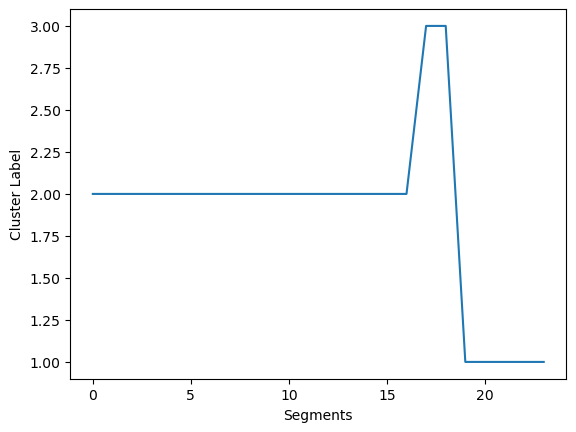

In [72]:
plt.plot(cluster_labels[0:24])
plt.xlabel("Segments")
plt.ylabel("Cluster Label")

###
From the above graph, it can be stated: Cluster 0 - Sit condition, Cluster 1 - Still condition, Cluster 2 - Walking condition, Cluster 3 - Fall condition

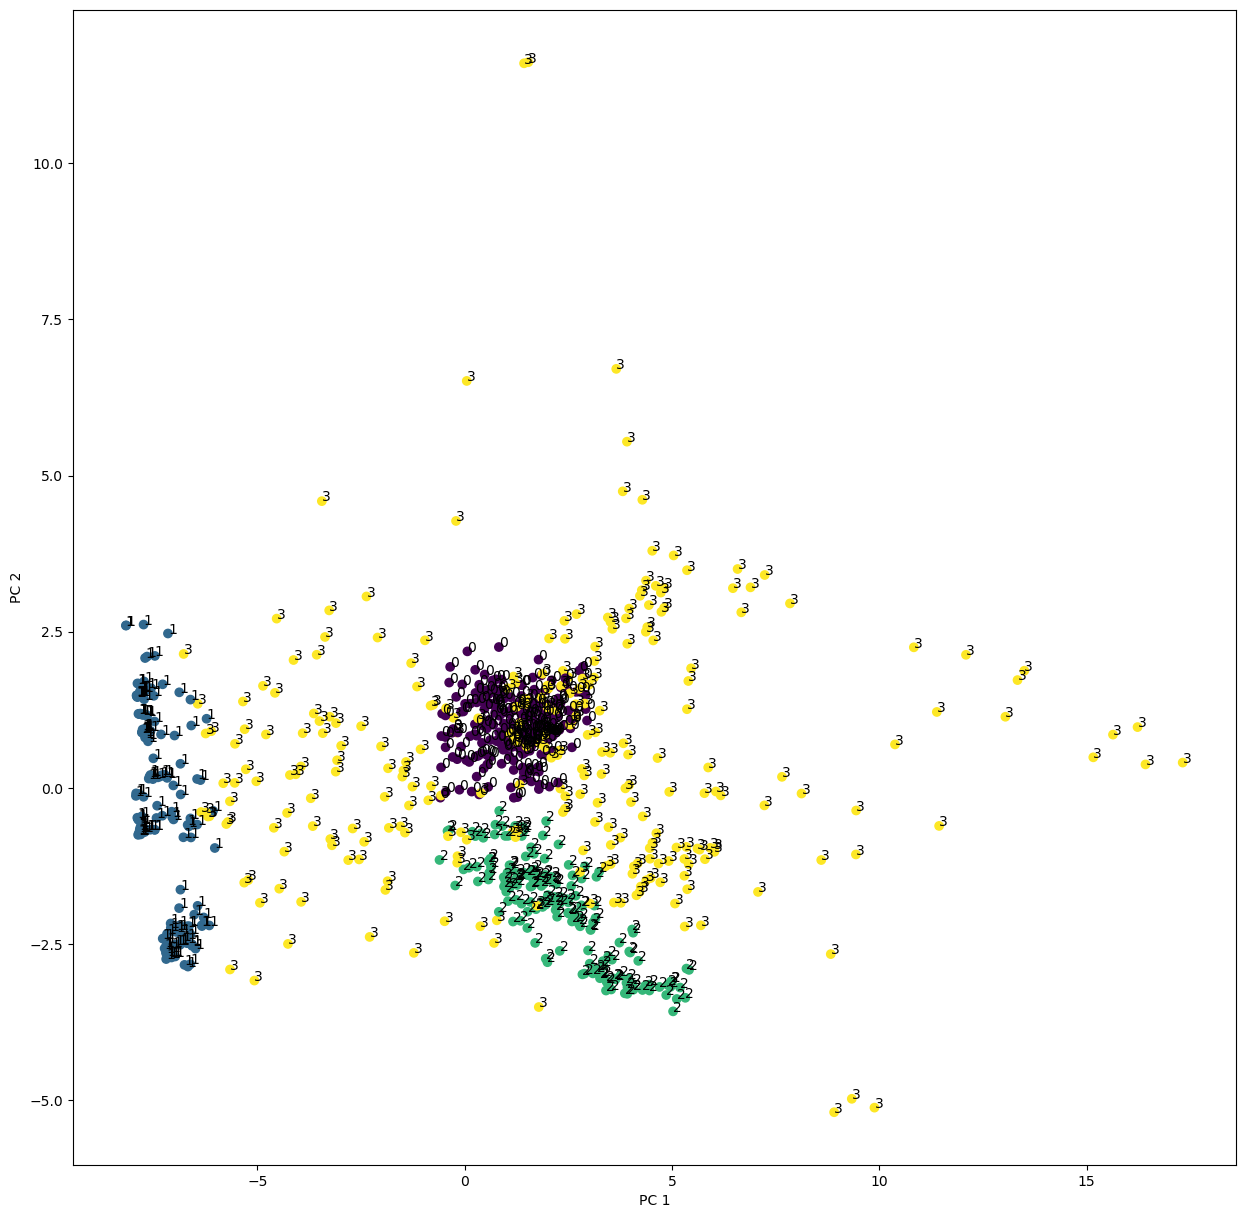

In [71]:
# 2D Scatter plot to visualize the clusters
fig1 = plt.figure(figsize=(15,15))
plt.scatter(transformed_features[:,0], transformed_features[:,1], c=cluster_labels)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# Give each point cluster labels
for i, j in zip(cluster_labels, range(len(cluster_labels))):
    plt.annotate(i, (transformed_features[j,0], transformed_features[j,1]))


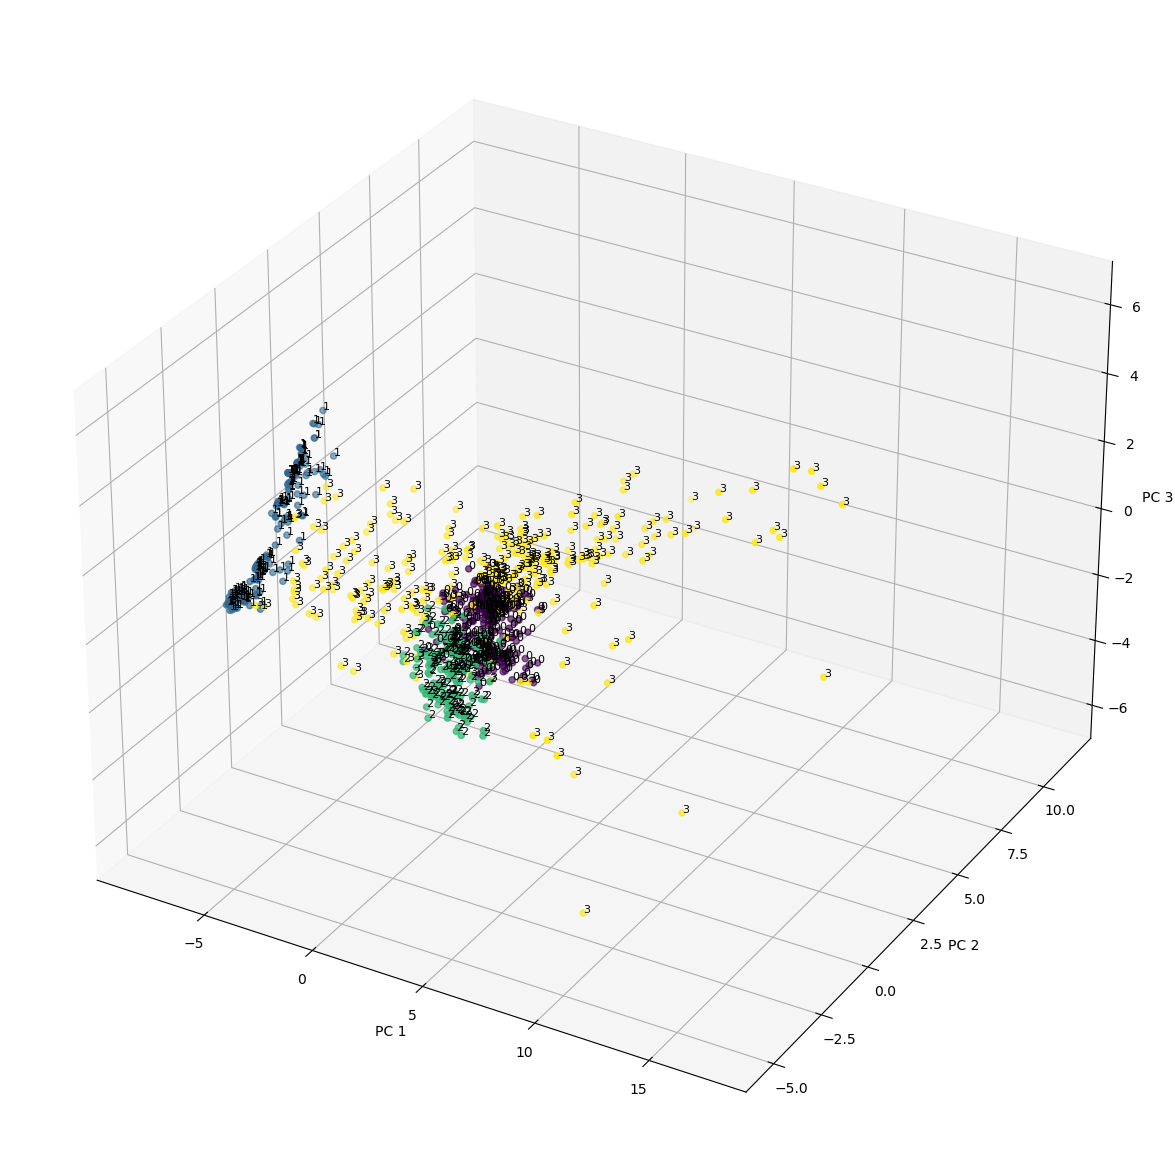

In [73]:
# 3D Scatter plot to visualize the clusters
fig2 = plt.figure(figsize=(15,15))
ax = fig2.add_subplot(projection='3d')
ax.scatter(transformed_features[:,0], transformed_features[:,1], transformed_features[:,2], c=cluster_labels)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

# Give each point cluster labels
for i, j in zip(cluster_labels, range(len(cluster_labels))):
    ax.text(transformed_features[j,0], transformed_features[j,1], transformed_features[j,2], "%s" % (str(i)), size=8)

# #// END_TODO [5ARB0_FallDetector_4_1]

### End of exercise 4.1
---
---

---
---
### Exercise 4.2: Fall classification
Use your fall detector to classify when someone has fallen. Plot your fall classification over time.

Text(0, 0.5, 'Cluster Label')

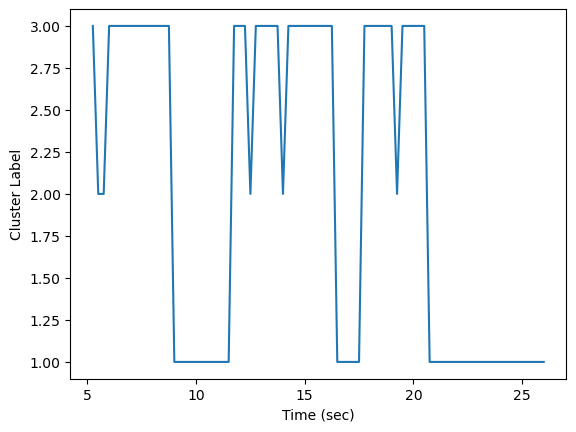

In [70]:
#// BEGIN_TODO [5ARB0_FallDetector_4_2] Classify falls

# Importing fall test that is seperate from the original dataset
fallTest_acc_csv = "./TestData_Aryan/test3/Accelerometer.csv"
fallTest_grav_csv = "./TestData_Aryan/test3/Gravity.csv"
fallTest_gyro_csv = "./TestData_Aryan/test3/Gyroscope.csv"

# test data loaded
fallTest_acc_df, fallTest_grav_df, fallTest_gyro_df = readDataFromCSV(fallTest_acc_csv, fallTest_grav_csv, fallTest_gyro_csv)

# test data pre-processing
fallTest_data = MergeDatasets(fallTest_acc_df, fallTest_grav_df, fallTest_gyro_df)
fallTest_norm = normaliseDataset(trimDataset(fallTest_data, fromStart=5, fromEnd=6))
fallTest_mat = fallTest_norm.to_numpy()

L = 50 # Segment length
K = 25 # Segment overlap

fallTest_Y_mean = process_segment(fallTest_mat, "mean", L, K)
fallTest_Y_std = process_segment(fallTest_mat, "std", L, K)
fallTest_Y_minimum = process_segment(fallTest_mat, "minimum", L, K)
fallTest_Y_maximum = process_segment(fallTest_mat, "maximum", L, K)

# Extract mean time data for all segments
fallTest_time_mean = fallTest_Y_mean[:,0]

# Remove time data
segment_list = [fallTest_Y_mean, fallTest_Y_std, fallTest_Y_minimum, fallTest_Y_maximum]

for i in range(len(segment_list)):
    segment_list[i] = np.delete(segment_list[i], 0, axis=1)

# Combine features
fallTest_features = np.hstack((segment_list[0], segment_list[1], segment_list[2], segment_list[3]))

# Fall detector test
trans_fallTest_features = pcaFit.transform(fallTest_features) # extract important features from test data
fallTest_labels = gmm.predict(trans_fallTest_features) # predict condition

# Plot labels with time
plotData = np.hstack((fallTest_labels, fallTest_time_mean))
plt.figure()
plt.plot(fallTest_time_mean, fallTest_labels)
plt.xlabel("Time (sec)")
plt.ylabel("Cluster Label")

#// END_TODO [5ARB0_FallDetector_4_2]

###
Notes from the above graph:
1. The GMM model can predict when a person remains still.
2. The model struggles to differentiate the 'walk conditon' and 'fall conditon'. In this test, the subject simulated fall at around 20 seconds.

### End of exercise 4.2
---
---

---
---
### Exercise 4.3: Classification improvements
You might have noticed that it is not easy to create a fall detector. How do you think that you could improve the performance? Please carefully describe the current flaws and ways to deal with them, together with a list of next steps that you would take. Please elaborate on your answer.

Current flaws with the model:

1. The current model does not take into account the different kinds of walk that people have along with the different kinds of fall people can experience. Due to this, the model cannot differentiate falling and walking. Thus, more data needs to be collected where more types of walking and fallings needs to be taken into consideration.
2. The data collection method has many uncertainties. For example, the data collection was carried out in phone where each of the participants kept phone in pocket. The orientaion of the phone and size of the pocket can affect the accuracy of data collection.


Next steps:

1. Collect data again where more types of 'simulated falls' performed.

### End of exercise 4.3
---
---

>   Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.